In [1]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore, mannwhitneyu
from msresist.figures.figureM2 import TumorType
sns.set(style="whitegrid", font_scale=1.2, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})
from msresist.pre_processing import preprocessing, FixColumnLabels, y_pre
from msresist.distances import DataFrameRipleysK
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from msresist.figures.figure1 import pca_dfs
from msresist.figures.figureM3 import build_pval_matrix, calculate_mannW_pvals, plot_clusters_binaryfeatures
from msresist.figures.figureM4 import merge_binary_vectors

In [2]:
with open('msresist/data/pickled_models/binomial/CPTACmodel_BINOMIAL_CL24_W15_TMT2', 'rb') as p:
    model = pickle.load(p)[0]

## Regression against methylation

In [54]:
mutations = pd.read_csv("msresist/data/MS/CPTAC/Patient_Mutations.csv").sort_values(by="Sample.ID").set_index("Sample.ID")
mtl = mutations["CIMP.status"]
mtl = mtl[~mtl.index.str.contains("IR")]

In [55]:
centers = pd.DataFrame(model.transform())
X = pd.read_csv("msresist/data/MS/CPTAC/CPTAC-preprocessedMotfis.csv").iloc[:, 1:]
centers["Patient_ID"] = X.columns[4:]
centers = centers.set_index("Patient_ID").sort_values(by="Patient_ID")
assert all(mtl.index == centers.index), "sampels not matching"

In [56]:
centers["drop"] = pd.isnull(mtl).values
centers = centers[centers["drop"] == False].iloc[:, :-1]

mtl = mtl.dropna()
assert all(centers.index == mtl.index), "samples not matching."

In [107]:
from statsmodels.stats.multitest import multipletests
def calculate_Kuskal_pvals(centers):
    """Plot Kuskal p-value vs cluster. Note that categorical variables should be converted to numerical."""
    ncl = max(centers.columns)
    cluster_samples = []
    for ii in range(ncl):
        samples = []
        for jj in range(max(centers.index) + 1):
            samples.append(centers.iloc[:, ii].loc[jj].values)
        cluster_samples.append(samples)
    pvals = []
    for c in cluster_samples:
        [*samples] = c
        pval = kruskal(*samples)[1]
        pvals.append(pval)
    # pvals = multipletests(pvals)[1] #p-value correction for multiple tests
    return pvals

In [108]:
centers["methylation status"] = mtl
centers = centers.replace("CIMP-2", 0)
centers = centers.replace("CIMP-1", 1)
centers = centers.replace("CIMP+", 2)
centers_ = centers.reset_index().iloc[:, 1:].set_index("methylation status")
centers_.columns = np.arange(model.ncl) + 1

In [137]:
pvals = calculate_Kuskal_pvals(centers_)

In [160]:
def plot_abundance_methylation(centers, cluster, ax):
    X = centers.loc[:, ["methylation status", cluster]]
    sns.stripplot(x="methylation status", y=cluster, data=X, color="darkblue", ax=ax)
    sns.boxplot(x="methylation status", y=cluster, data=X, color="white", linewidth=2, ax=ax)
    ax.set_xticklabels(["CIMP-2", "CIMP-1", "CIMP+"])
    ax.set_title("p-site Abundance")
    ax.set_ylabel("Cluster " + str(cluster))

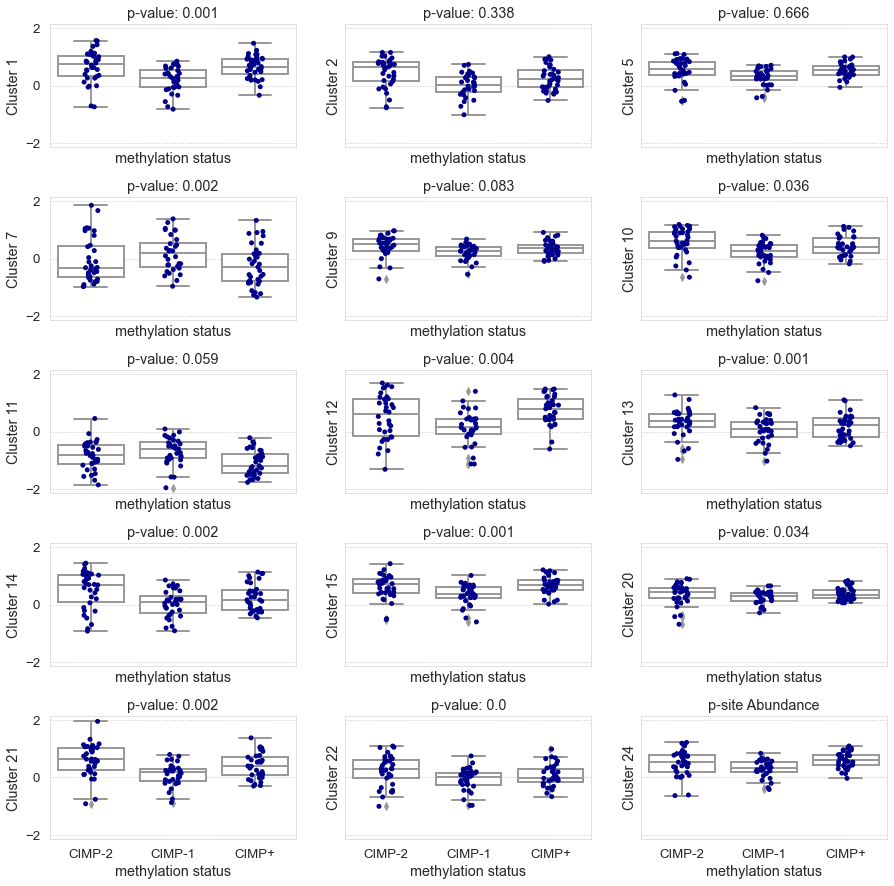

In [164]:
_, ax = plt.subplots(5, 3, figsize=(15, 15), sharex=True, sharey=True)
ax = ax.flatten()
sc = np.where(np.array(pvals) < 0.05)[0]
for ii, c in enumerate(sc):
    c += 1
    plot_abundance_methylation(centers_.reset_index(), c, ax[ii])
    ax[ii-1].set_title("p-value: " + str(np.round(pvals[ii], 3)))

plt.subplots_adjust(wspace=.2, hspace=.4)